In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from src.datareader import datareader as dr

<h3>Initialize Data Readers</h3>

In [2]:
# ufs_data_reader = dr.getDataReader(datasource='UFS', filename="experiments/phase_1/baseline/atm_monthly.zarr", model='atm')
# era5_data_reader = dr.getDataReader(datasource='ERA5', filename="1959-2022-6h-1440x721.zarr/") # <-- 6hr, high resolution data

ufs_data_reader = dr.getDataReader(datasource='UFS', model='atm')
era5_data_reader = dr.getDataReader(datasource='ERA5') # <-- 6hr, lower-resolution data by default

No filename provided; deferring to default
Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/baseline/atm_monthly.zarr
UFS dataset loaded.
Standardizing coordinate system
Dataset read.
No filename provided; deferring to default
Reading data from gs://gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr/
ERA5 dataset loaded.
Standardizing coordinate system
Sorting lat descending
Dataset read.


In [ ]:
# ufs_data_reader.describe()

In [ ]:
# era5_data_reader.describe()

<h3>Retrieve DataSets</h3>

In [3]:
time_range = ("1994-05-01","2021-05-31T23")

In [4]:
# Retrieve a UFS dataset
# The complete dataset is preserved after retrieval
ufs_ds = ufs_data_reader.retrieve(
    var = 'tmpsfc',
    time=time_range,
    ens_avg=True
) 

Slicing by init
Taking Ensemble Average


In [ ]:
# ufs_ds.tmpsfc

In [5]:
# Retrieve an ERA5 dataset 
# The complete dataset is preserved after retrieval
era5_ds = era5_data_reader.retrieve(
    var='sea_surface_temperature',
    time=time_range
)

Slicing by time


<h3>Regrid</h3>

In [6]:
from src.regridder import Regrid

<h3>Initialize Regridder</h3>

In [7]:
regridder = Regrid.Regrid(data_reader1=ufs_data_reader,
                          data_reader2=era5_data_reader,
                          method='bilinear')

Verification grid set to data_reader2
Initializing Regridder with method 'bilinear'
Regridder initialized.


In [8]:
aligned = regridder.align(
    var='sea_surface_temperature',
    time=time_range)


DEBUG: Starting alignment process
Slicing by time
Slicing by init
auto_resample set to True
DEBUG: Interpreting lead as monthly intervals
DEBUG: Resampling verification data to 'MS' using mean aggregation.
Number of cores available: 12
Concatenating resample results
Resampling done in 0.38994752168655394 minutes.
Running scalar regrid on sea_surface_temperature
Completed scalar regrid in 0.019237784544626872 minutes.
DEBUG: Auto-selected tolerance = 16 days

DEBUG: Alignment complete — matched=217, filled with NaNs=3
DEBUG: Alignment complete.
Standardizing coordinate system
Dataset read.


In [51]:
def plot_robinson(dataslice, title):

    projection = ccrs.Robinson()
    crs = ccrs.PlateCarree()
    levels = np.linspace(200,320,25)
    
    plt.figure(figsize=(14,7), dpi=100)
    ax = plt.axes(projection=projection)
    ax.set_global()
    dataslice.plot(ax=ax, transform=crs, levels=levels) #, vmin=200, vmax=320)
    ax.coastlines()
    
    if 'time' in list(dataslice.coords):
        title = f"{title} TIME {str(dataslice.time.values)}"
        
    elif 'init' in list(dataslice.coords):
        title = f"{title} INIT {str(dataslice.init.values)}"
        
    plt.title(f"{title}")
    
    return plt

<module 'matplotlib.pyplot' from '/home/cstan/miniforge/envs/ufs_client/lib/python3.11/site-packages/matplotlib/pyplot.py'>

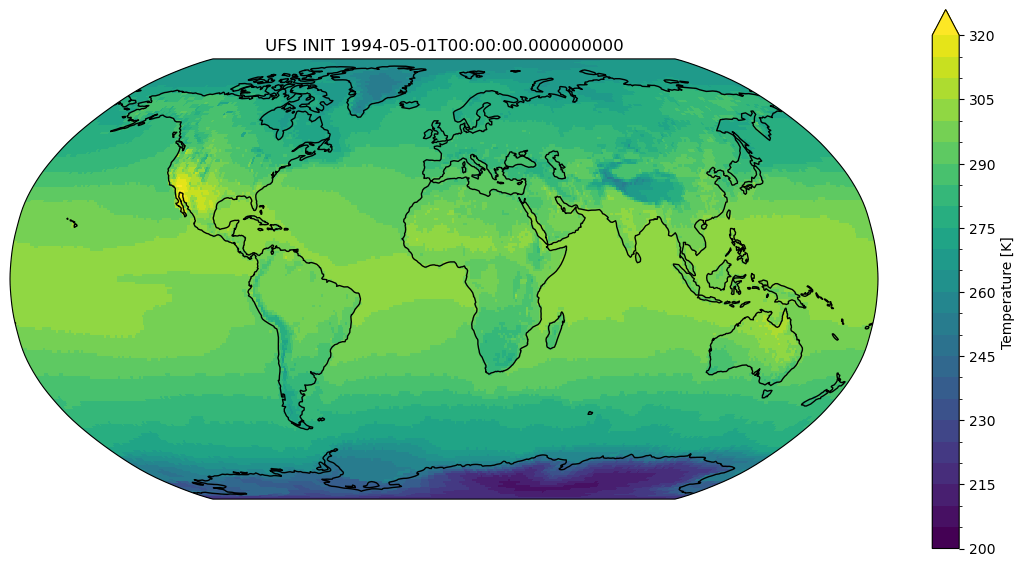

In [52]:
dataslice = ufs_ds.isel(init=0, lead=0)['tmpsfc']
plot_robinson(dataslice, 'UFS')

<module 'matplotlib.pyplot' from '/home/cstan/miniforge/envs/ufs_client/lib/python3.11/site-packages/matplotlib/pyplot.py'>

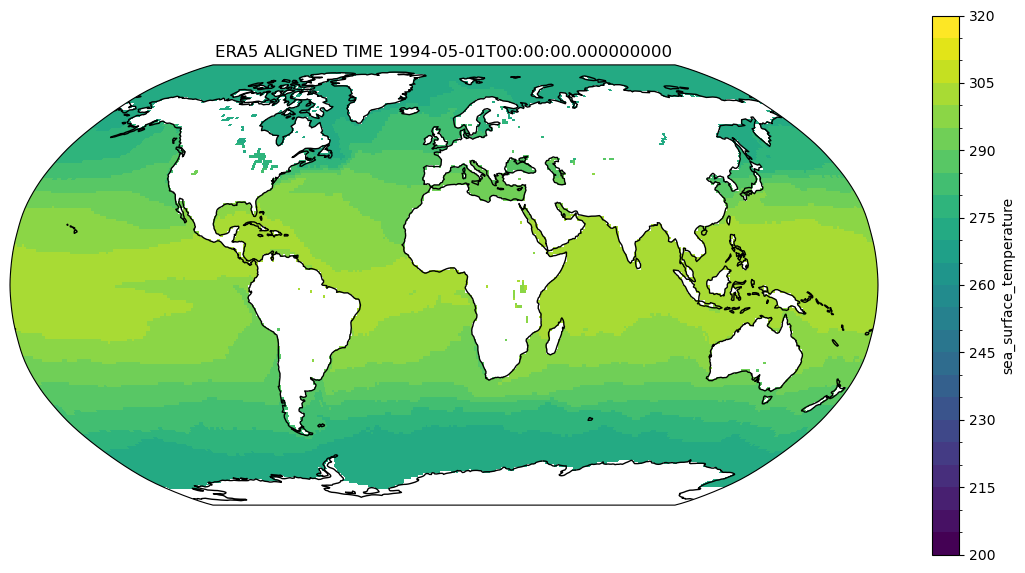

In [53]:
dataslice = aligned.dataset.isel(init=0, lead=0)['sea_surface_temperature']
plot_robinson(dataslice, 'ERA5 ALIGNED')

In [66]:
ufs_ds['tmpsfc'].sel(lat=slice(5,-5),lon=slice(190,240))

<xarray.DataArray 'tmpsfc' (init: 55, lead: 4, lat: 10, lon: 54)> Size: 475kB
dask.array<getitem, shape=(55, 4, 10, 54), dtype=float32, chunksize=(1, 1, 10, 54), chunktype=numpy.ndarray>
Coordinates:
  * init     (init) datetime64[ns] 440B 1994-05-01 1994-11-01 ... 2021-05-01
  * lat      (lat) float64 80B 4.208 3.273 2.338 1.403 ... -2.338 -3.273 -4.208
  * lead     (lead) int64 32B 0 1 2 3
  * lon      (lon) float64 432B 190.3 191.2 192.2 193.1 ... 238.1 239.1 240.0
Attributes:
    long_name:  Temperature
    units:      K

In [111]:
aligned.dataset['sea_surface_temperature'].sel(lat=slice(5,-5),lon=slice(190,240))[:,54,:,:]

<xarray.DataArray 'sea_surface_temperature' (lead: 4, lat: 10, lon: 54)> Size: 9kB
array([[[301.52472, 301.51004, 301.48618, ..., 301.1735 , 301.2513 ,
         301.33023],
        [301.5284 , 301.5278 , 301.50497, ..., 300.95697, 301.0869 ,
         301.1307 ],
        [301.46634, 301.46582, 301.43762, ..., 300.47415, 300.64166,
         300.66742],
        ...,
        [301.66412, 301.72894, 301.6085 , ..., 299.8513 , 299.79684,
         299.73593],
        [301.83835, 301.85364, 301.73114, ..., 300.00513, 299.9571 ,
         299.89194],
        [301.9879 , 301.94983, 301.8481 , ..., 300.00226, 299.94833,
         299.89102]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    time                   (lead) datetime64[ns] 32B 2021-05-01 ... 1994-05-01
    atmosphereSingleLayer  float64 8B 0.0
    heightAboveGround      float64 8B 2.0
    meanSea                float64 8B 0.0
    nominalTop             float64 8B 0.0
    surface                float64 8B 0.0
  * lat                    (lat) float64 80B 4.208 3.273 2.338 ... -3.273 -4.208
  * lon                    (lon) float64 432B 190.3 191.2 192.2 ... 239.1 240.0
    init                   datetime64[ns] 8B 2021-05-01
  * lead                   (lead) int64 32B 0 1 2 3

<h3>Calculate Nino3.4 Index for UFS and ERA5</h3>

In [69]:
fcstnino34=ufs_ds['tmpsfc'].sel(lat=slice(5,-5),lon=slice(190,240)).mean(['lat','lon'])
verifnino34=aligned.dataset['sea_surface_temperature'].sel(lat=slice(5,-5),lon=slice(190,240)).mean(['lat','lon'])

fcstclimo = fcstnino34.groupby('init.month').mean('init')
fcst = (fcstnino34.groupby('init.month') - fcstclimo)

verifclimo = verifnino34.groupby('init.month').mean('init')
verif = (verifnino34.groupby('init.month') - verifclimo)

<h3>Calculate Anomaly Correlation as a Function of Initial Month and Lead</h3>

In [59]:
def compute_correlation(ds1,ds2):
    
    # Initialize result array (leads, number of initial months)
    skill=np.zeros((ds1['lead'].size, 2))
    
    for lead_idx in range(ds1['lead'].size):
        # Extract the lead time colimns
        fcstds = ds1[:,lead_idx]  # shape: (55,)
        verifds = ds2[lead_idx,:] #shape: (55,)
    
        # Combine the two columns for corrcoef
        combined = np.vstack([fcstds,verifds]) #shape: (2,55)
    
        # Compute corrleation matrix using np.corrcoef
        corr_matrix = np.corrcoef(combined) #shape: (2,2)
    
        # Extract relevant correlation
        # corr_matrix[0,0] = corr(col1, col1) = 1.0
        # corr_matrix[0,1] = corr(col1, col2) = correlation we want
        # corr_matrix[1,0] = corr(col2, col1) = same as [0,1]
        # corr_matrix[1,1] = corr(col2, col2) = 1.0
        base_corr = corr_matrix[0, 1]
    
        # Fill the initial months
        skill[lead_idx,:] = base_corr
    return skill

In [70]:
acc = compute_correlation(fcst,verif)

In [71]:
acc

array([[0.99232972, 0.99232972],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan]])